# How to crawling? - Naver Real Estate Map

In [1]:
#import custom module
import nre.con as nc
import nre.util as nu
from IPython.display import clear_output 

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

서울시 강남구 대치동 1168010600 loc(37.499110 | 127.065463)


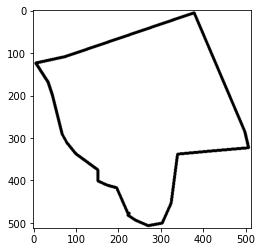

In [19]:
#loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

#https://new.land.naver.com/complexes?ms=37.49911,127.065463,16&a=APT:OPST&b=B1:A1&e=RETAIL&s=EE

cur_region = nc.NRegion('', loc, '0000000000')

# 검색해서 지역 찾기
# while True:
#     regions = nu.get_region_list(cur_region.no)
#     if len(regions) == 0: break
#     for i, region in enumerate(regions): 
#         print(i, region)
        
#     idx = int(input("원하는 도시 인덱스(exit -1) : "))
#     clear_output()
#     if idx == -1: break
#     cur_region = regions[idx]
    
sector = nu.get_sector(cur_region.loc)

print(sector)

#구역 모양
for img in sector.map.get_img():
    plt.imshow(img, cmap='gray')

## 매물 조건 생성

In [3]:
addon = nc.NAddon(
    #direction=nc.NAddon.DIR_EACH, #전 방향 탐색의 경우 사용 - 아래 로직을 바꾸세요
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

## 조건과 구역을 이용하여 매물 탐색

In [4]:
things = [] # 매물 기록
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.dir = dirr # 매물 방향 선택
    values = []
    for v in nu.get_things(sector, addon):
        if sector.map.is_in(v.loc) is False: # 구역 포함되어있는지
            removed += 1 
            continue 
        v.dir = dirr # 매물 방향 정의
        values.append(v)
    things.extend(values)
print('올바른 매물 수', len(things), '제거됨', removed)

올바른 매물 수 142 제거됨 17


## 구역 주변 편의 시설 탐색

In [5]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = []
    res = nu.get_neighborhood(sector.loc, nType)
    
    for r in res:
        if sector.map.is_in(r.loc):
            values.append(r)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 47
METRO 2
INFANT 29
PRESCHOOL 3
SCHOOLPOI 20
HOSPITAL 0
PARKING 68
MART 11
CONVENIENCE 79
WASHING 35
BANK 38
OFFICE 6
Total 338


# 편의시설과 매물 간의 거리 탐색

In [6]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value)

BUS 500
METRO 500
INFANT 750
PRESCHOOL 750
SCHOOLPOI 2000
HOSPITAL 5000
PARKING 500
MART 500
CONVENIENCE 250
WASHING 500
BANK 1000
OFFICE 2000


In [7]:
for thing in things: # 매물
    around = nc.NNeighborAround()
    for nei in neighbors: # 편의시설
        d = nu.distance_between(thing.loc, nei.loc)
        if d <= standard[nei.type]: # meter
            around.increase(nei.type)
    thing.neiAround = around

## 시각화

In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

thing_df = pd.DataFrame(data=[t.get_list() for t in things] ,columns=nc.NThing.HEADER)
nei_df = pd.DataFrame(data=[t.neiAround.get_list() for t in things], columns=nc.NNeighborAround.HEADER)

total_df = pd.concat([thing_df, nei_df], axis=1)
total_df['sector'] = sector.name

total_df

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,sector
0,세영팔래스,APT,200201,EE,73.77,103.37,103.0,237,175000.0,200000.0,...,3,20,0,20,1,10,14,35,6,대치동
1,삼환SOGOOD(주상복합),APT,200611,EE,107.38,133.52,133.0,359,220000.0,220000.0,...,2,20,0,16,2,7,10,32,6,대치동
2,대치대우아이빌명문가(주상복합),APT,200402,EE,41.88,53.58,41.0,637,31000.0,38000.0,...,1,20,0,23,3,14,10,18,6,대치동
3,대치대우아이빌명문가,OPST,200402,EE,57.05,59.01,57.0,637,31000.0,32000.0,...,1,20,0,23,3,14,10,18,6,대치동
4,동양,APT,199901,EE,112.14,112.14,112.0,223,NaN,NaN,...,2,20,0,16,2,6,12,20,6,대치동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,동양,APT,199901,WN,112.14,112.14,112.0,223,NaN,NaN,...,2,20,0,16,2,6,12,20,6,대치동
138,대치클래시아,OPST,201512,WN,42.36,61.63,61.0,0,51000.0,65000.0,...,1,20,0,10,4,7,8,26,6,대치동
139,바실리체,OPST,202203,WN,67.34,153.29,67.0,799,86000.0,370000.0,...,1,20,0,22,2,6,8,19,6,대치동
140,청원,APT,200502,WN,114.52,114.72,114.0,260,NaN,NaN,...,2,20,0,19,3,10,12,33,6,대치동


In [11]:
total_df.describe()

,representativeArea,floorAreaRatio,minDeal,maxDeal,medianDeal,minLease,maxLease,medianLease,minDealUnit,maxDealUnit,...,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,142.000000,142.000000,127.000000,127.000000,127.000000,120.000000,120.000000,103.000000,127.000000,127.000000,...,142.000000,142.000000,142.0,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,99.070423,354.549296,177212.598425,246393.700787,192353.149606,107583.333333,153129.166667,123330.097087,5623.937008,6533.645669,...,13.647887,1.633803,20.0,0.0,18.359155,2.514085,8.105634,9.774648,23.950704,6.0
std,43.509785,251.068344,120745.214498,168972.015974,132532.701228,70281.339890,101186.957671,79925.165777,2471.007284,2804.177656,...,4.755284,0.699330,0.0,0.0,5.567563,1.397749,4.406165,3.138402,6.551842,0.0
min,32.000000,0.000000,26000.000000,29000.000000,27750.000000,19000.000000,19000.000000,23000.000000,1569.000000,1846.000000,...,8.000000,0.000000,20.0,0.0,4.000000,0.000000,0.000000,4.000000,14.000000,6.0
25%,67.000000,243.000000,71500.000000,107500.000000,78650.000000,65000.000000,70000.000000,67500.000000,3474.500000,4011.000000,...,10.000000,1.000000,20.0,0.0,15.250000,2.000000,6.000000,8.000000,19.000000,6.0
50%,94.000000,267.500000,185000.000000,220000.000000,185000.000000,100000.000000,117500.000000,110000.000000,5797.000000,6494.000000,...,12.000000,2.000000,20.0,0.0,19.000000,2.000000,7.000000,10.000000,22.000000,6.0
75%,124.000000,434.000000,252500.000000,370000.000000,260000.000000,140750.000000,220000.000000,162500.000000,7189.000000,8531.000000,...,16.000000,2.000000,20.0,0.0,22.000000,3.000000,12.000000,12.000000,30.000000,6.0
max,225.000000,1096.000000,505000.000000,560000.000000,510000.000000,450000.000000,450000.000000,450000.000000,10093.000000,11702.000000,...,26.000000,3.000000,20.0,0.0,34.000000,6.000000,16.000000,19.000000,37.000000,6.0


In [12]:
nei_df.describe() 

,BUS,METRO,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,142.000000,142.000000,142.000000,142.000000,142.0,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,9.676056,0.204225,13.647887,1.633803,20.0,0.0,18.359155,2.514085,8.105634,9.774648,23.950704,6.0
std,4.271876,0.454118,4.755284,0.699330,0.0,0.0,5.567563,1.397749,4.406165,3.138402,6.551842,0.0
min,4.000000,0.000000,8.000000,0.000000,20.0,0.0,4.000000,0.000000,0.000000,4.000000,14.000000,6.0
25%,6.000000,0.000000,10.000000,1.000000,20.0,0.0,15.250000,2.000000,6.000000,8.000000,19.000000,6.0
50%,8.000000,0.000000,12.000000,2.000000,20.0,0.0,19.000000,2.000000,7.000000,10.000000,22.000000,6.0
75%,14.000000,0.000000,16.000000,2.000000,20.0,0.0,22.000000,3.000000,12.000000,12.000000,30.000000,6.0
max,18.000000,2.000000,26.000000,3.000000,20.0,0.0,34.000000,6.000000,16.000000,19.000000,37.000000,6.0


## 방향에 따른 가격

<AxesSubplot:xlabel='Dir', ylabel='maxDeal'>

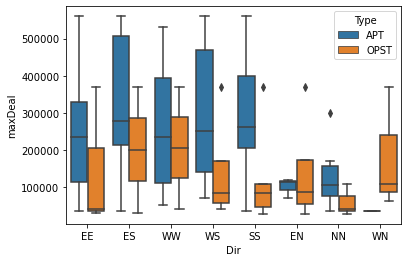

In [15]:
sns.boxplot(x='Dir', y = 'maxDeal', hue='Type', data=total_df)

## 오피스텔과 아파트 차이

<AxesSubplot:xlabel='Type', ylabel='maxDeal'>

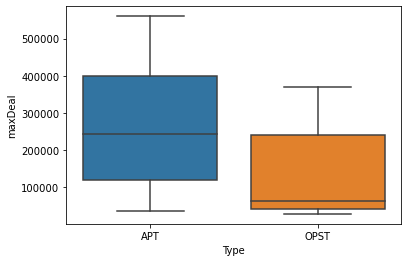

In [20]:
sns.boxplot(x='Type', y = 'maxDeal', data=total_df)

## 저장

In [ ]:
total_df.to_csv('./csv/%s - %s house_price.csv' % (sector.name, sector.city), sep=',', na_rep='NaN', index=False)